# Libs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import torch

# Ej. 1

In [ ]:
# Centros de las gaussianas
r_0 = [10,0]
r_1 = [0,10]
r_2 = [-10,0]
r_3 = [0,-10]
r_4 = [0,0]
N = 100 # Numero de puntos por gaussiana
sigma = 3 # Desviacion estandar

# Generar puntos
X_0 = np.random.randn(N,2) * sigma + r_0
X_1 = np.random.randn(N,2) * sigma + r_1
X_2 = np.random.randn(N,2) * sigma + r_2
X_3 = np.random.randn(N,2) * sigma + r_3
X_4 = np.random.randn(N,2) * sigma + r_4

plt.scatter(X_0[:,0], X_0[:,1], color='orange', label='Clase 0')
plt.scatter(X_1[:,0], X_1[:,1], color='red', label='Clase 1')
plt.scatter(X_2[:,0], X_2[:,1], color='brown', label='Clase 2')
plt.scatter(X_3[:,0], X_3[:,1], color='black', label='Clase 3')
plt.scatter(X_4[:,0], X_4[:,1], color='blue', label='Clase 4')

# # genero un punto random - a clasificar
# p0 = np.random.randn(1,2) * 10 # un punto radom de dos dimenciones con media 10
# plt.scatter(p0[:,0],p0[:,1], color='k', label='Punto a clasificar')



plt.legend()
plt.show()


In [ ]:
N_Neighbors = 10

# Lista de clases
X_list = [X_0, X_1, X_2, X_3, X_4]

# Calculo distancias euclidianas para cada clase
distances = [np.linalg.norm(X - p0, axis=1) for X in X_list]

# Concateno todas las distancias y obtengo los N_Neighbors más cercanos
all_distances = np.concatenate(distances)
nearest_indices = np.argpartition(all_distances, N_Neighbors)[:N_Neighbors]
nearest_distances = all_distances[nearest_indices]

# Contar vecinos por clase
counts = np.zeros(len(X_list), dtype=int)
for d in nearest_distances:
    for i, dist in enumerate(distances):
        if d in dist:
            counts[i] += 1
            break

print("Vecinos por clase:", counts)


def classify_point(p0):
    distance = [np.linalg.norm(X - p0, axis=1) for X in X_list]
    all_distances = np.concatenate(distance)
    nearest_indices = np.argpartition(all_distances, N_Neighbors)[:N_Neighbors]
    nearest_distances = all_distances[nearest_indices]

    # Contar vecinos por clase
    counts = np.zeros(len(X_list), dtype=int)
    for d in nearest_distances:
        for i, dist in enumerate(distance):
            if d in dist:
                counts[i] += 1
                break

    print("Vecinos por clase:", counts)
    return np.argmax(counts)




In [ ]:

N_Neighbors = 15
# genero una grilla
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)

#clasifico los puntos y pinto el area 
# Creamos una matriz para guardar la clase predicha en cada punto de la grilla
Z = np.zeros((len(x), len(y)), dtype=int)

for i in range(len(x)):
    for j in range(len(y)):
        punto = np.array([[x[i], y[j]]])
        clase = classify_point(punto)
        Z[i, j] = clase

# Graficamos el área de decisión
plt.contourf(x, y, Z.T, alpha=0.3, levels=np.arange(6)-0.5, cmap='tab10')
# Volvemos a graficar los puntos originales y el punto a clasificar
plt.scatter(X_0[:,0], X_0[:,1], color='orange', label='Clase 0')
plt.scatter(X_1[:,0], X_1[:,1], color='red', label='Clase 1')
plt.scatter(X_2[:,0], X_2[:,1], color='brown', label='Clase 2')
plt.scatter(X_3[:,0], X_3[:,1], color='black', label='Clase 3')
plt.scatter(X_4[:,0], X_4[:,1], color='blue', label='Clase 4')

# plt.scatter(p0[:,0], p0[:,1], color='k', label='Punto a clasificar')
plt.legend()
plt.show()

        
        


#   Ej. 2

## Métodos

In [ ]:
def clasificar_k_nearest(x_train, y_train, im_0, NN):
    ## si son numpy array los paso a clasificar _k_nearest_np
    if isinstance(im_0, np.ndarray):
        return clasificar_k_nearest_np(x_train, y_train, im_0, NN)
    ## si son tensores torch los paso a clasificar _k_nearest_torch
    elif isinstance(im_0, torch.Tensor):
        return clasificar_k_nearest_torch(x_train, y_train, im_0, NN)
    else:
        raise ValueError("im_0 debe ser un numpy array o un tensor torch")


def clasificar_k_nearest_np(x_train, y_train, im_0, NN):

    #euclideana
    # distances = np.linalg.norm(x_train - im_0, axis=1)
    #coseno
    distances = 1 - (x_train @ im_0) / (np.linalg.norm(x_train, axis=1) * np.linalg.norm(im_0))

    idx_part = np.argpartition(distances, kth=NN-1)[:NN] # Indices de los NN vecinos más cercanos, kth es NN-1 es el pivot, a la izquierda los menores a la derecha los mayores
    nearest_labels = y_train[idx_part]

    #plot los mas cercanos
    # for i in range(NN):
    #     plt.imshow(x_train[idx_part[i]].reshape(28,28), cmap='gray')
    #     plt.title(f"Etiqueta: {y_train[idx_part[i]]}")
    #     plt.show()


    counts = np.bincount(nearest_labels, minlength=10) # Cuento las etiquetas, minlength=10 para asegurar todas las clases del 0 al 9
    return np.argmax(counts)

def clasificar_k_nearest_torch(d_x_train, d_y_train, d_im_0, NN):
    eps = 1e-8

    # Asegurar que sea tensor 2D
    if d_im_0.ndim == 1:
        d_im_0 = d_im_0.unsqueeze(0)  # (1, 3072)

    # Distancias euclídeas al cuadrado (más rápido que sqrt)
    # ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x·y
    # d2 = torch.sum(d_x_train**2, dim=1) - 2 * (d_x_train @ d_im_0.T).squeeze() + torch.sum(d_im_0**2)

    # distancia coseno
    d2  = 1 - (d_x_train @ d_im_0.T).squeeze() / (torch.norm(d_x_train, dim=1) * torch.norm(d_im_0))
    
    # Tomar índices de los NN más cercanos
    _, idx = torch.topk(d2, k=NN, largest=False)
    nearest_labels = d_y_train[idx]

    # Contar votos (con bincount)
    counts = torch.bincount(nearest_labels, minlength=10)
    pred = torch.argmax(counts)
    return pred.item()


## mnist

In [ ]:
#mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() # en x tengo las imagenes y en y las etiquetas

#paso a devise


#print cuantos datos hay
print("Cantidad de datos de entrenamiento:", x_train.shape[0])
print("Cantidad de datos de test:", x_test.shape[0])

#serializo las imagenes y las normalizo

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.float32, device=device).reshape(60000, -1) / 255.0
x_test  = torch.tensor(x_test, dtype=torch.float32, device=device).reshape(10000, -1) / 255.0
y_train = torch.tensor(y_train.flatten(), dtype=torch.long, device=device)
y_test  = torch.tensor(y_test.flatten(), dtype=torch.long, device=device)



#pruebo con una imagen del test
ii = 11
im_0 = x_test[ii]
plt.imshow(im_0.cpu().reshape(28,28), cmap='gray')
plt.show()
print("Etiqueta real:", y_test[ii])
print("Etiqueta clasificada:", clasificar_k_nearest(x_train, y_train, im_0, 10))


# creo la matriz de confusion con los primeros 1000 datos de test
confusion_matrix = np.zeros((10, 10), dtype=int)
for i in range(len(x_test[:1000])):
    im_0 = x_test[i]
    true_label = y_test[i]
    predicted_label = clasificar_k_nearest(x_train, y_train, im_0, 5)
    confusion_matrix[true_label, predicted_label] += 1

#print la matriz de confusion
print("Matriz de confusión:")
print(confusion_matrix)



In [ ]:
# Normalizar por filas
confusion_matrix_norm = confusion_matrix.astype(float) / confusion_matrix.sum(axis=1, keepdims=True)

print("Matriz de confusión normalizada (por filas):")
np.set_printoptions(precision=2, suppress=True)
print(confusion_matrix_norm)


In [ ]:
## cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
clases = ['avion', 'automovil', 'pajaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camion']

print("Cantidad de datos de entrenamiento:", x_train.shape[0])
print("Cantidad de datos de test:", x_test.shape[0])

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") 

x_train = torch.tensor(x_train, dtype=torch.float32, device=device).reshape(50000, -1) / 255.0
x_test  = torch.tensor(x_test, dtype=torch.float32, device=device).reshape(10000, -1) / 255.0
y_train = torch.tensor(y_train.flatten(), dtype=torch.long, device=device)
y_test  = torch.tensor(y_test.flatten(), dtype=torch.long, device=device)


ii = 10
im_0 = x_test[ii]
plt.imshow(im_0.cpu().reshape(32,32,3))
plt.axis("off")
plt.show()

print("Etiqueta real:", clases[y_test[ii].item()])
pred_label = clasificar_k_nearest(x_train, y_train, im_0, 10)
print("Etiqueta clasificada:", clases[pred_label])

confusion_matrix = torch.zeros((10, 10), dtype=torch.int64)
for i in range(len(x_test[:1000])):
    im_0 = x_test[i]
    true_label = y_test[i].item()
    predicted_label = clasificar_k_nearest(x_train, y_train, im_0, 50)
    confusion_matrix[true_label, predicted_label] += 1

print("Matriz de confusión:")
print(confusion_matrix.cpu().numpy())

# Ej. 3

In [ ]:
class LinearClassifier:
    def __init__(self, input_dim, num_classes, device):
        self.W = torch.randn(input_dim, num_classes, device=device) * 0.01
        self.b = torch.zeros(num_classes, device=device)
        self.device = device

    def forward(self, x):
        return x @ self.W + self.b # operacion matricial

    def train(self, x_train, y_train, learning_rate=1e-3, epochs=1):
        epoch_losses = []
        for epoch in range(epochs):
            loss, dW, db = self.compute_loss_and_gradients(x_train, y_train)
            self.W -= learning_rate * dW # actualizo los pesos
            self.b -= learning_rate * db # actualizo los bias
            epoch_losses.append(loss.item())
            # if epoch % 1 == 0:
                # print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        return sum(epoch_losses) / len(epoch_losses)

    def predict(self, x):
        scores = self.forward(x)
        return torch.argmax(scores, dim=1) # devuelve la clase con mayor score

# heredo y hago un Support Vector Machine y un Softmax Classifier
class SVMClassifier(LinearClassifier):

    def compute_loss_and_gradients(self, x, y, delta=1.0, reg=1e-3):
        num_train = x.shape[0]
        scores = self.forward(x)
        correct_class_scores = scores[torch.arange(num_train), y].unsqueeze(1)
        margins = torch.clamp(scores - correct_class_scores + delta, min=0)
        margins[torch.arange(num_train), y] = 0
        loss = margins.sum() / num_train

        loss += 0.5 * reg * torch.sum(self.W ** 2)

        # Gradientes
        binary = (margins > 0).float()
        row_sum = binary.sum(dim=1)
        binary[torch.arange(num_train), y] = -row_sum
        dW = x.T @ binary / num_train
        db = binary.sum(dim=0) / num_train

        dW += reg * self.W

        return loss, dW, db
    
class SoftmaxClassifier(LinearClassifier):
    def compute_loss_and_gradients(self, x, y):
        # x: (N, D), y: (N,), W: (D, C), b: (C,)

        num_train = x.shape[0] # cantidad de ejemplos
        scores = self.forward(x) # calculo los scores  (N, C)

        scores -= scores.max(dim=1, keepdim=True).values  # resta el max en cada fila para estabilidad numérica (softmax es invariante ante traslaciones)
        exp_scores = torch.exp(scores)  # (N, C)
        probs = exp_scores / exp_scores.sum(dim=1, keepdim=True) # calculo la probabilidad # (N, C)

        eps = 1e-12
        correct_logprobs = -torch.log(probs[torch.arange(num_train), y] + eps)  # log de la probabilidad correcta
        loss = correct_logprobs.mean() 

        # Gradientes
        dscores = probs.clone() # (N, C)
        dscores[torch.arange(num_train), y] -= 1 # le resto 1 a la probabilidad correcta
        dscores /= num_train # normalizo los gradientes

        dW = x.T @ dscores  #multiplico por el input    (D, N) @ (N, C) = (D, C)
        db = dscores.sum(dim=0) # sumo los gradientes   (C,)

        return loss, dW, db


In [ ]:

# # # mnist
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() # en x tengo las imagenes y en y las etiquetas

# #print len
# print("Cantidad de datos de entrenamiento:", x_train.shape[0])
# print("Cantidad de datos de test:", x_test.shape[0])

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# x_train = torch.tensor(x_train, dtype=torch.float32, device=device).reshape(60000, -1) / 255.0
# x_test  = torch.tensor(x_test, dtype=torch.float32, device=device).reshape(10000, -1) / 255.0
# y_train = torch.tensor(y_train.flatten(), dtype=torch.long, device=device)
# y_test  = torch.tensor(y_test.flatten(), dtype=torch.long, device=device)
# input_dim = x_train.shape[1]
# num_classes = 10


In [ ]:
#cifar 10
# Cargar
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print("Cantidad de datos de entrenamiento:", x_train.shape[0])
print("Cantidad de datos de test:", x_test.shape[0])

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# A [0,1] y forma (N, C, H, W)
x_train = torch.tensor(x_train, dtype=torch.float32, device=device) / 255.0
x_test  = torch.tensor(x_test,  dtype=torch.float32, device=device) / 255.0
x_train = x_train.permute(0, 3, 1, 2)  # (N, 3, 32, 32)
x_test  = x_test.permute(0, 3, 1, 2)

# Estandarización por canal
mean = x_train.mean(dim=(0, 2, 3), keepdim=True)
std  = x_train.std(dim=(0, 2, 3), keepdim=True)
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

# Aplanar a (N, 3072)
x_train = x_train.reshape(x_train.size(0), -1)
x_test  = x_test.reshape(x_test.size(0), -1)

y_train = torch.tensor(y_train.flatten(), dtype=torch.long, device=device)
y_test  = torch.tensor(y_test.flatten(),  dtype=torch.long, device=device)

input_dim   = x_train.shape[1]   # 3072
num_classes = 10

In [ ]:
n_epochs = 1000
batch_size = 1000

svm = SVMClassifier(input_dim, num_classes, device)
accuracies_svm = []
Losses_svm = []

for epoch in range(n_epochs):

    indices = torch.randperm(x_train.shape[0])[:]
    partial_loss = 0.0
    for i in range(x_train.shape[0] // batch_size):
        batch_indices = indices[i*batch_size:(i+1)*batch_size]
        loss = svm.train( x_train[batch_indices], y_train[batch_indices], learning_rate=1e-3, epochs=1)
        partial_loss += loss
    
    Losses_svm.append(partial_loss/ (x_train.shape[0] // batch_size))
    y_pred = svm.predict(x_test)
    accuracy = (y_pred == y_test).float().mean().item()
    accuracies_svm.append(accuracy)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Accuracy: {accuracy:.4f}, Loss: {partial_loss/ (x_train.shape[0] // batch_size):.4f}")

In [ ]:
n_epochs = 1000
batch_size = 1000


softmax = SoftmaxClassifier(input_dim, num_classes, device)
accuracies_soft = []
Losses_soft = []

for epoch in range(n_epochs):

    indices = torch.randperm(x_train.shape[0])[:]
    partial_loss = 0.0

    for i in range(x_train.shape[0] // batch_size):
        batch_indices = indices[i*batch_size:(i+1)*batch_size]
        loss = softmax.train( x_train[batch_indices], y_train[batch_indices], learning_rate=1e-3, epochs=1)
        partial_loss += loss
    Losses_soft.append(partial_loss/ (x_train.shape[0] // batch_size))
    y_pred = softmax.predict(x_test)
    accuracy = (y_pred == y_test).float().mean().item()
    accuracies_soft.append(accuracy)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Accuracy: {accuracy:.4f}, Loss: {partial_loss/ (x_train.shape[0] // batch_size):.4f}")
    

In [ ]:

plt.plot(accuracies_soft,"o-", label='Softmax')
plt.plot(accuracies_svm,"o-", label='SVM')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xscale('log')
# plt.ylim(bottom=0.4)
plt.show()

plt.plot(Losses_soft,"o-", label='Softmax')
plt.plot(Losses_svm,"o-", label='SVM')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xscale('log')
# plt.ylim(top=3)
plt.show()

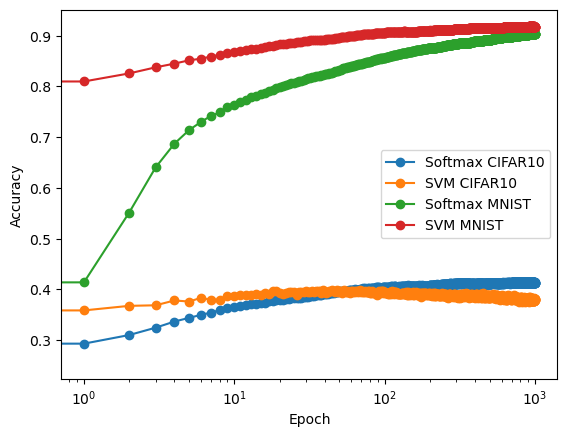

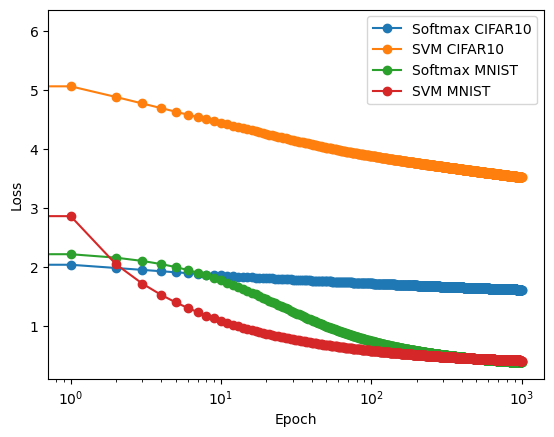

In [109]:
#open accuracies_soft_CIFAR10, accuracies_svm_CIFAR10, Losses_soft_CIFAR10, Losses_svm_CIFAR10, accuracies_soft_MNIST, accuracies_svm_MNIST, Losses_soft_MNIST, Losses_svm_MNIST
accuracies_soft_CIFAR10 = np.load("accuracies_soft_CIFAR10.npy")
accuracies_svm_CIFAR10  = np.load("accuracies_svm_CIFAR10.npy")
Losses_soft_CIFAR10     = np.load("Losses_soft_CIFAR10.npy")
Losses_svm_CIFAR10      = np.load("Losses_svm_CIFAR10.npy")

accuracies_soft_MNIST   = np.load("accuracies_soft_MINIST.npy")
accuracies_svm_MNIST    = np.load("accuracies_svm_MINIST.npy")
Losses_soft_MNIST       = np.load("Losses_soft_MINIST.npy")
Losses_svm_MNIST        = np.load("Losses_svm_MINIST.npy")

#plt accuracies en un mismo grafico y loss en otro

plt.plot(accuracies_soft_CIFAR10,"o-", label='Softmax CIFAR10')
plt.plot(accuracies_svm_CIFAR10,"o-", label='SVM CIFAR10')
plt.plot(accuracies_soft_MNIST,"o-", label='Softmax MNIST')
plt.plot(accuracies_svm_MNIST,"o-", label='SVM MNIST')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xscale('log')
plt.show()

plt.plot(Losses_soft_CIFAR10,"o-", label='Softmax CIFAR10')
plt.plot(Losses_svm_CIFAR10,"o-", label='SVM CIFAR10')
plt.plot(Losses_soft_MNIST,"o-", label='Softmax MNIST')
plt.plot(Losses_svm_MNIST,"o-", label='SVM MNIST')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xscale('log')